# Spark Architecture/Setup

In [1]:
from pyspark.sql import *

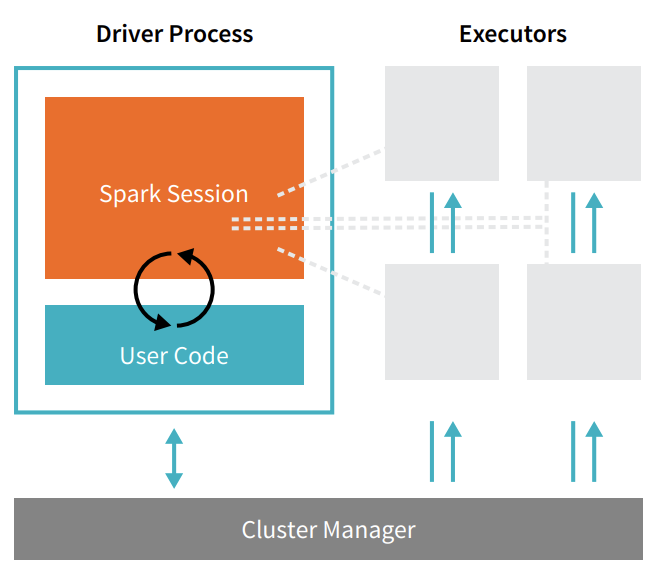

#### Driver:maintaining information about the Spark Application; responding to a user’s program or input; and analyzing, distributing, and scheduling work across the executors
#### Executor: executing code assigned to it by the driver and reporting the state of the computation
#### Cluster manager: cluster manager controls physical machines and allocates resources to Spark Applications.

#### SparkSession available to the user, the SparkSession will be the entrance point to running Spark code. When using Spark from a Python or R, the user never writes explicit JVM instructions, but instead writes Python and R code that Spark will translate into code that Spark can then run on the executor JVMs.

In [2]:
spark = (SparkSession.builder.appName("DE-Intro").getOrCreate())

In [8]:
type(spark)

pyspark.sql.session.SparkSession

In [9]:
flight_file = './data/2015-summary.csv'
flight_df = (spark.read.format("csv")
             .option("header","true")
             .option("inferSchema","true")
             .load(flight_file))

In [10]:
flight_df.select("*").show()

+--------------------+-------------------+-----+
|   DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+--------------------+-------------------+-----+
|       United States|            Romania|   15|
|       United States|            Croatia|    1|
|       United States|            Ireland|  344|
|               Egypt|      United States|   15|
|       United States|              India|   62|
|       United States|          Singapore|    1|
|       United States|            Grenada|   62|
|          Costa Rica|      United States|  588|
|             Senegal|      United States|   40|
|             Moldova|      United States|    1|
|       United States|       Sint Maarten|  325|
|       United States|   Marshall Islands|   39|
|              Guyana|      United States|   64|
|               Malta|      United States|    1|
|            Anguilla|      United States|   41|
|             Bolivia|      United States|   30|
|       United States|           Paraguay|    6|
|             Algeri

In [11]:
#first 3 rows
flight_df.take(3)

[Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=15),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Croatia', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Ireland', count=344)]

## Partition Count

In [12]:
flight_df.sort("count").explain()

== Physical Plan ==
*(1) Sort [count#18 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(count#18 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#44]
   +- FileScan csv [DEST_COUNTRY_NAME#16,ORIGIN_COUNTRY_NAME#17,count#18] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/C:/Users/SEXYALPACA/PySpark/data/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,ORIGIN_COUNTRY_NAME:string,count:int>




In [13]:
#reduce the number of the output partitions from the shuffle from two hundred to five.
spark.conf.set("spark.sql.shuffle.partitions", "5")

In [14]:
flight_df.sort("count").explain()
#note this line - rangepartitioning(count#18 ASC NULLS FIRST, 5)
#prior to setting partition count its 200 - rangepartitioning(count#18 ASC NULLS FIRST, 200)

== Physical Plan ==
*(1) Sort [count#18 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(count#18 ASC NULLS FIRST, 5), ENSURE_REQUIREMENTS, [id=#56]
   +- FileScan csv [DEST_COUNTRY_NAME#16,ORIGIN_COUNTRY_NAME#17,count#18] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/C:/Users/SEXYALPACA/PySpark/data/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,ORIGIN_COUNTRY_NAME:string,count:int>




In [15]:
#Increasing the partition count makes it run faster! But at what point does it begin to baseline
spark.conf.set("spark.sql.shuffle.partitions", "400")
flight_df.take(3)

[Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=15),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Croatia', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Ireland', count=344)]

## Dataframes, TempViews and SQL

In [16]:
# there is no performance difference between writing SQL queries or writing DataFrame code, they
# both "compile" to the same underlying plan that we specify in DataFrame code.
flight_df.createOrReplaceTempView("flight_temp_view")

In [17]:
# note that spark.sql function RETURNS a new dataframe as dataframes are immutable
# compare two plans - SQL versus Dataframe querying - will be IDENTICAL
sqlWay = spark.sql("""
        SELECT DEST_COUNTRY_NAME, count(1) as count
        FROM flight_temp_view
        GROUP BY DEST_COUNTRY_NAME
        """)

dataFrameWay = flight_df \
    .groupBy("DEST_COUNTRY_NAME") \
    .count().alias("count")

sqlWay.explain()
dataFrameWay.explain()

== Physical Plan ==
*(2) HashAggregate(keys=[DEST_COUNTRY_NAME#16], functions=[count(1)])
+- Exchange hashpartitioning(DEST_COUNTRY_NAME#16, 400), ENSURE_REQUIREMENTS, [id=#85]
   +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#16], functions=[partial_count(1)])
      +- FileScan csv [DEST_COUNTRY_NAME#16] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/C:/Users/SEXYALPACA/PySpark/data/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>


== Physical Plan ==
*(2) HashAggregate(keys=[DEST_COUNTRY_NAME#16], functions=[count(1)])
+- Exchange hashpartitioning(DEST_COUNTRY_NAME#16, 400), ENSURE_REQUIREMENTS, [id=#104]
   +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#16], functions=[partial_count(1)])
      +- FileScan csv [DEST_COUNTRY_NAME#16] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/C:/Users/SEXYALPACA/PySpark/data/2015-summary.csv], PartitionFilters: [], PushedFilters

In [18]:
# max transformation
print("spark sql: ", spark.sql("SELECT max(count) from flight_temp_view").take(1))
#print("using df: ", flight_df.select(max("count")).take(1))

spark sql:  [Row(max(count)=370002)]


#### The execution plans for the below follow a directed acyclic graph (DAG) of transformations, each resulting in a new immutable DataFrame, on which we call an action to generate a result. Remember, Lazy Eval
#### Refer to the dataframe query for a more specific take

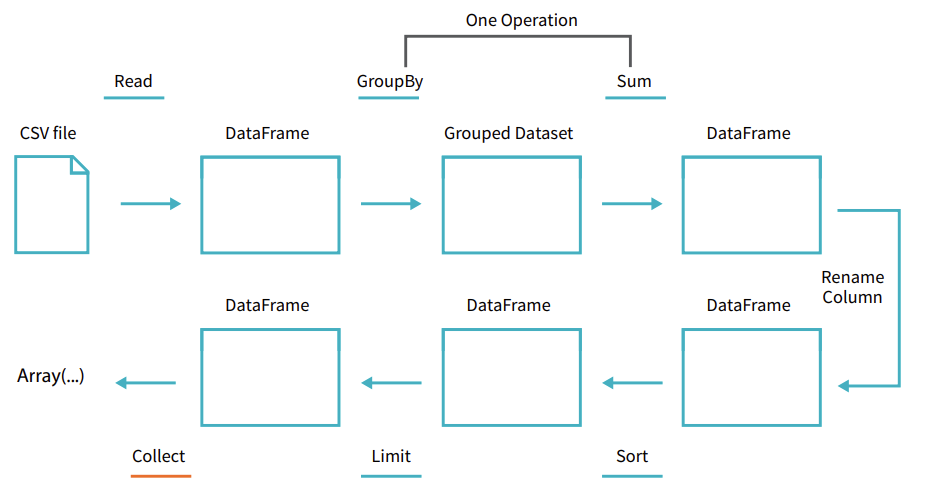

In [19]:
# aggregation - top five destination countries in the data
maxSql = spark.sql("""
SELECT DEST_COUNTRY_NAME, sum(count) as destination_total
FROM flight_temp_view
GROUP BY DEST_COUNTRY_NAME
ORDER BY sum(count) DESC
LIMIT 5
""")

maxSql.collect()

[Row(DEST_COUNTRY_NAME='United States', destination_total=411352),
 Row(DEST_COUNTRY_NAME='Canada', destination_total=8399),
 Row(DEST_COUNTRY_NAME='Mexico', destination_total=7140),
 Row(DEST_COUNTRY_NAME='United Kingdom', destination_total=2025),
 Row(DEST_COUNTRY_NAME='Japan', destination_total=1548)]

In [20]:
#all lines are transformations until the collect which is an action

flight_df \
    .groupBy("DEST_COUNTRY_NAME")\ 
    .sum("count")\ #transformation
    .withColumnRenamed("sum(count)", "destination_total")\ 
    .sort("destination_total", ascending=False)\ 
    .limit(5)\ 
    .collect() #action that sets it ALL off

## Don’t always have to collect the data. We can also write it out to any data source (Database, file, etc.)

SyntaxError: unexpected character after line continuation character (<ipython-input-20-28f358a36548>, line 4)

In [21]:
#explain plan
flight_df\
    .groupBy("DEST_COUNTRY_NAME")\
    .sum("count")\
    .withColumnRenamed("sum(count)", "destination_total")\
    .sort("destination_total", ascending=False)\
    .limit(5)\
    .explain()

== Physical Plan ==
TakeOrderedAndProject(limit=5, orderBy=[destination_total#85L DESC NULLS LAST], output=[DEST_COUNTRY_NAME#16,destination_total#85L])
+- *(2) HashAggregate(keys=[DEST_COUNTRY_NAME#16], functions=[sum(cast(count#18 as bigint))])
   +- Exchange hashpartitioning(DEST_COUNTRY_NAME#16, 400), ENSURE_REQUIREMENTS, [id=#170]
      +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#16], functions=[partial_sum(cast(count#18 as bigint))])
         +- FileScan csv [DEST_COUNTRY_NAME#16,count#18] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/C:/Users/SEXYALPACA/PySpark/data/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,count:int>




## Sparks Toolset
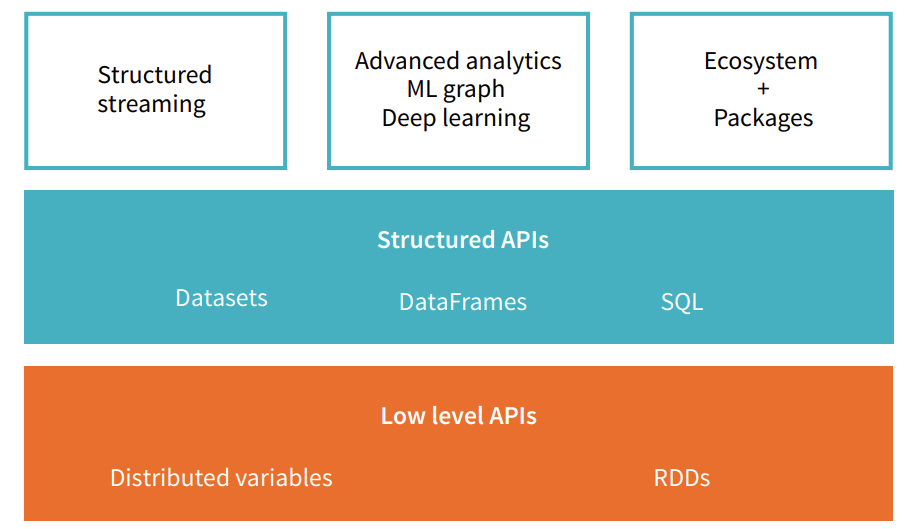

### spark-submit allows you to submit your applications to a currently managed cluster to run

./bin/spark-submit \
 --master local \
 ./examples/src/main/python/pi.py 10
 
 ./bin/spark-submit \
 --class org.apache.spark.examples.SparkPi \
 --master local \
 ./examples/jars/spark-examples_2.11-2.2.0.jar 10

### Datasets: Type-Safe Structured API's
is a type-safe version of Spark’s structured API for Java and Scala, called Datasets. This API is not available in Python and R, because those are dynamically typed languages, but it is a powerful tool for writing large applications in Scala and Java. (Come back to this later)

### Structured Streaming
Structured Streaming is a high-level API for stream processing. Structured
Streaming allows you to take the same operations that you perform in batch mode using Spark’s structured APIs, and
run them in a streaming fashion. This can reduce latency and allow for incremental processing. Easy to reason about because you can write your batch job as a way to prototype it and
then you can convert it to streaming job. The way all of this works is by incrementally processing that data.

In [4]:
#Scenario - retail data set where each file represents a day of data
staticDataFrame = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("./data/retail-data/by-day/2010-12-01.csv")
    #.load("./data/retail-data/by-day/*.csv")

staticDataFrame.createOrReplaceTempView("retail_data")
staticSchema = staticDataFrame.schema

In [7]:
from pyspark.sql.functions import window, column, desc, col

#largest sale hours where a given customer (identified by CustomerId) makes a large purchase
#The window function will include all data from each day in the aggregation. 
#It’s simply a window over the time series column in our data
#null values represent the fact that we don’t have a customerId for some transactions.

staticDataFrame\
    .selectExpr(
    "CustomerId",
    "(UnitPrice * Quantity) as total_cost" ,
    "InvoiceDate" )\
    .groupBy(col("CustomerId"), window(col("InvoiceDate"), "1 day"))\
    .sum("total_cost")\
    .show(5)

+----------+--------------------+------------------+
|CustomerId|              window|   sum(total_cost)|
+----------+--------------------+------------------+
|   13408.0|{2010-11-30 19:00...|1024.6800000000003|
|   17460.0|{2010-11-30 19:00...|              19.9|
|   15235.0|{2010-11-30 19:00...|              79.5|
|   17905.0|{2010-11-30 19:00...|201.74999999999997|
|   12583.0|{2010-11-30 19:00...|            855.86|
+----------+--------------------+------------------+
only showing top 5 rows



#### Not so different from batch code, here we use readStream instead of read, additionally you’ll notice maxFilesPerTrigger option which simply specifies the number of files we should read in at once. This is to make our demonstration more "streaming" and in a production scenario this would be omitted.

In [ ]:
streamingDataFrame = spark.readStream\
    .schema(staticSchema)\
    .option("maxFilesPerTrigger", 1)\
    .format("csv")\
    .option("header", "true")\
    .load("./data/retail-data/by-day/2010-12-01.csv")

In [ ]:
#check if streaming
streamingDataFrame.isStreaming

In [ ]:
#test summation - remember, this is a lazy eval so nothing occurs til we call a streaming action
purchaseByCustomerPerHour = streamingDataFrame\
    .selectExpr(
    "CustomerId",
    "(UnitPrice * Quantity) as total_cost" ,
    "InvoiceDate" )\
    .groupBy(col("CustomerId"), window(col("InvoiceDate"), "1 day"))\
    .sum("total_cost")

In [ ]:
purchaseByCustomerPerHour.writeStream\
    .format("memory")\
    .queryName("customer_purchases")\
    .outputMode("complete")\
    .start()

In [ ]:
#Once we start the stream, we can run queries against the stream to debug what our result will look like if we were to
#write this out to a production sink.
spark.sql("""
    SELECT *
    FROM customer_purchases
    ORDER BY `sum(total_cost)` DESC
    """)\
    .show(5)

### Machine Learning and Advanced Analytics (Come back to this)
Provides for the ability to perform large scale machine learning with a built-in library of machine
learning algorithms called MLlib

### Lower Level API's 
Spark includes a number of lower level primitives to allow for arbitrary Java and Python object manipulation via
Resilient Distributed Datasets (RDDs). Virtually everything in Spark is built on top of RDDs and compiles down to these lower level tools for convenientand extremely efficient distributed execution. May use when you’re reading or manipulating raw data, but for the most part you should stick to the Structured APIs. 

RDDs are lower level that DataFrames because they reveal physical execution characteristics (like partitions) to end users.
One thing you might use RDDs for is to parallelize raw data you have stored in memory on the driver machine.

### Spark's Ecosystem and Packages can be found here
https://spark-packages.org/

## Working with different Types of Data

In [3]:
df = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("./data/retail-data/by-day/2010-12-01.csv")

df.printSchema()
df.createOrReplaceTempView("dfTable")

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [4]:
#spark.sql("select * from dfTable").show(10)
df.select("*").show(10)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United Kingdom|
|   536365|    21730|GLASS S

### Converting to Spark types

In [5]:
#lit takes a type in a native language and convert it into the Spark representation
from pyspark.sql.functions import lit
df.select(lit(5), lit("five"), lit(5.0))

DataFrame[5: int, five: string, 5.0: double]

### Booleans and Equality
to filter by equality you should use === (equal) or =!= (not equal). You can also use not function and the equalTo method

In [6]:
from pyspark.sql.functions import col

df.where(col("InvoiceNo") != 536365)\
    .select("InvoiceNo", "Description")\
    .show(5, False)

+---------+-----------------------------+
|InvoiceNo|Description                  |
+---------+-----------------------------+
|536366   |HAND WARMER UNION JACK       |
|536366   |HAND WARMER RED POLKA DOT    |
|536367   |ASSORTED COLOUR BIRD ORNAMENT|
|536367   |POPPY'S PLAYHOUSE BEDROOM    |
|536367   |POPPY'S PLAYHOUSE KITCHEN    |
+---------+-----------------------------+
only showing top 5 rows



In [7]:
# another way is to specify the predicate as an expression in a string
df.select("InvoiceNo", "Description").where("InvoiceNo <> 536365").show(5, False) 

+---------+-----------------------------+
|InvoiceNo|Description                  |
+---------+-----------------------------+
|536366   |HAND WARMER UNION JACK       |
|536366   |HAND WARMER RED POLKA DOT    |
|536367   |ASSORTED COLOUR BIRD ORNAMENT|
|536367   |POPPY'S PLAYHOUSE BEDROOM    |
|536367   |POPPY'S PLAYHOUSE KITCHEN    |
+---------+-----------------------------+
only showing top 5 rows



In [8]:
# AND logic - can specify statements serially/apart
# Spark will flatten all of these filters into one statement and perform the filter at the same time, 
# creating the and statement for us, can specify explicitly

from pyspark.sql.functions import instr

priceFilter = col("UnitPrice") > 600

descripFilter = instr(df.Description, "POSTAGE") >= 1

df.where(df.StockCode.isin("DOT"))\
    .where(priceFilter | descripFilter)\
    .show()

+---------+---------+--------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|   Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------+--------+-------------------+---------+----------+--------------+
|   536544|      DOT|DOTCOM POSTAGE|       1|2010-12-01 14:32:00|   569.77|      null|United Kingdom|
|   536592|      DOT|DOTCOM POSTAGE|       1|2010-12-01 17:06:00|   607.49|      null|United Kingdom|
+---------+---------+--------------+--------+-------------------+---------+----------+--------------+



In [9]:
# OR logic
priceFilter = col("UnitPrice") > 600

descripFilter = instr(df.Description, "POSTAGE") >= 1

df.where(df.StockCode.isin("DOT"))\
    .where(priceFilter | descripFilter)\
    .show()

+---------+---------+--------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|   Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------+--------+-------------------+---------+----------+--------------+
|   536544|      DOT|DOTCOM POSTAGE|       1|2010-12-01 14:32:00|   569.77|      null|United Kingdom|
|   536592|      DOT|DOTCOM POSTAGE|       1|2010-12-01 17:06:00|   607.49|      null|United Kingdom|
+---------+---------+--------------+--------+-------------------+---------+----------+--------------+



In [10]:
# can specify BOOLEAN column
DOTCodeFilter = col("StockCode") == "DOT"

priceFilter = col("UnitPrice") > 600

descripFilter = instr(col("Description"), "POSTAGE") >= 1

df.withColumn("isExpensive",
    DOTCodeFilter & (priceFilter | descripFilter))\
    .where("isExpensive")\
    .select("unitPrice", "isExpensive")\
    .show(5)

+---------+-----------+
|unitPrice|isExpensive|
+---------+-----------+
|   569.77|       true|
|   607.49|       true|
+---------+-----------+



In [11]:
#can use where or filter
from pyspark.sql.functions import expr

df.withColumn("isExpensive", expr("NOT UnitPrice <= 250")) \
    .where("isExpensive") \
    .select("Description", "UnitPrice") \
    .show(5)

+--------------+---------+
|   Description|UnitPrice|
+--------------+---------+
|DOTCOM POSTAGE|   569.77|
|DOTCOM POSTAGE|   607.49|
+--------------+---------+



In [12]:
#performing a null safe equivalence test
df.where(col("Description").eqNullSafe("hello")).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
+---------+---------+-----------+--------+-----------+---------+----------+-------+



### Numbers

In [13]:
# to the power of
from pyspark.sql.functions import expr, pow

fabricatedQuantity = pow(col("Quantity") * col("UnitPrice"), 2) + 5

df.select(
    col("CustomerId"),
    fabricatedQuantity.alias("realQuantity"))\
    .show(2)

+----------+------------------+
|CustomerId|      realQuantity|
+----------+------------------+
|   17850.0|239.08999999999997|
|   17850.0|          418.7156|
+----------+------------------+
only showing top 2 rows



In [14]:
# add / subtract
df.selectExpr(
    "CustomerId",
    "(POWER((Quantity * UnitPrice), 2.0) + 5) as realQuantity").show(2)

+----------+------------------+
|CustomerId|      realQuantity|
+----------+------------------+
|   17850.0|239.08999999999997|
|   17850.0|          418.7156|
+----------+------------------+
only showing top 2 rows



In [15]:
# rounding
# remember, lit creates a literal out of whatever is passed in
from pyspark.sql.functions import lit, round, bround

df.select(
    round(lit("2.5")),
    lit("HEHE"),
    bround(lit("2.5")))\
    .show(2)

+-------------+----+--------------+
|round(2.5, 0)|HEHE|bround(2.5, 0)|
+-------------+----+--------------+
|          3.0|HEHE|           2.0|
|          3.0|HEHE|           2.0|
+-------------+----+--------------+
only showing top 2 rows



In [16]:
# correlation
# compute the correlation of two columns. For example, we can see the Pearson
# Correlation Coefficient for two columns to see if cheaper things are typically bought in greater quantities.
from pyspark.sql.functions import corr

#df.stat.corr("Quantity", "UnitPrice")

df.select(corr("Quantity", "UnitPrice")).show()

+-------------------------+
|corr(Quantity, UnitPrice)|
+-------------------------+
|     -0.04112314436835551|
+-------------------------+



In [17]:
# describe method - to compute summary statistics
df.describe().show()

+-------+-----------------+------------------+--------------------+------------------+-------------------+------------------+------------------+--------------+
|summary|        InvoiceNo|         StockCode|         Description|          Quantity|        InvoiceDate|         UnitPrice|        CustomerID|       Country|
+-------+-----------------+------------------+--------------------+------------------+-------------------+------------------+------------------+--------------+
|  count|             3108|              3108|                3098|              3108|               3108|              3108|              1968|          3108|
|   mean| 536516.684944841|27834.304044117645|                null| 8.627413127413128|               null| 4.151946589446603|15661.388719512195|          null|
| stddev|72.89447869788873|17407.897548583845|                null|26.371821677029203|               null|15.638659854603892|1854.4496996893627|          null|
|    min|           536365|             

In [18]:
# various statistical functions
from pyspark.sql.functions import count, mean, stddev_pop, min, max

# see a cross tabulation or frequent item pairs
#df.stat.crosstab("StockCode", "Quantity").show() 
#df.stat.freqItems(["StockCode", "Quantity"]).show()

In [19]:
# monotonically increasing id
from pyspark.sql.functions import monotonically_increasing_id
df.select("CustomerID", monotonically_increasing_id()).show(2)

+----------+-----------------------------+
|CustomerID|monotonically_increasing_id()|
+----------+-----------------------------+
|   17850.0|                            0|
|   17850.0|                            1|
+----------+-----------------------------+
only showing top 2 rows



### Strings

In [20]:
# initcap function will capitalize first char of every word in a given string 
# when that word is separated from another via whitespace.

from pyspark.sql.functions import initcap
df.select(col("Description")).show(3)
df.select(initcap(col("Description"))).show(3)

+--------------------+
|         Description|
+--------------------+
|WHITE HANGING HEA...|
| WHITE METAL LANTERN|
|CREAM CUPID HEART...|
+--------------------+
only showing top 3 rows

+--------------------+
|initcap(Description)|
+--------------------+
|White Hanging Hea...|
| White Metal Lantern|
|Cream Cupid Heart...|
+--------------------+
only showing top 3 rows



In [21]:
# upper and lower case funcs
from pyspark.sql.functions import lower, upper

df.select(
    col("Description"),
    lower(col("Description")),
    upper(col("Description")))\
    .show(2)

+--------------------+--------------------+--------------------+
|         Description|  lower(Description)|  upper(Description)|
+--------------------+--------------------+--------------------+
|WHITE HANGING HEA...|white hanging hea...|WHITE HANGING HEA...|
| WHITE METAL LANTERN| white metal lantern| WHITE METAL LANTERN|
+--------------------+--------------------+--------------------+
only showing top 2 rows



In [22]:
# lpad, ltrim, rpad and rtrim, trim.
# if lpad or rpad takes a number less than the length of the string, it will always remove values from
# the right side of the string.
from pyspark.sql.functions import lit, ltrim, rtrim, rpad, lpad, trim
df.select(
    ltrim(lit(" HELLO ")).alias("ltrim"),
    rtrim(lit(" HELLO ")).alias("rtrim"),
    trim(lit(" HELLO ")).alias("trim"),
    lpad(lit("HELLO"), 3, " ").alias("lp"),
    rpad(lit("HELLO"), 10, " ").alias("rp"))\
    .show(2)

+------+------+-----+---+----------+
| ltrim| rtrim| trim| lp|        rp|
+------+------+-----+---+----------+
|HELLO | HELLO|HELLO|HEL|HELLO     |
|HELLO | HELLO|HELLO|HEL|HELLO     |
+------+------+-----+---+----------+
only showing top 2 rows



###  Regex

In [23]:
# regexp_replace
from pyspark.sql.functions import regexp_replace
regex_string = "BLACK|WHITE|RED|GREEN|BLUE"


#if desc has word any color mentioned in regex_string, replace it with word COLOR"

df.select(
    regexp_replace(col("Description"), regex_string, "COLOR").alias("color_cleaned"),
    col("Description"))\
    .show(2, False)

+----------------------------------+----------------------------------+
|color_cleaned                     |Description                       |
+----------------------------------+----------------------------------+
|COLOR HANGING HEART T-LIGHT HOLDER|WHITE HANGING HEART T-LIGHT HOLDER|
|COLOR METAL LANTERN               |WHITE METAL LANTERN               |
+----------------------------------+----------------------------------+
only showing top 2 rows



In [24]:
# translate func
# done at the character level and will replace all instances of a character with the 
# indexed character in the replacement string
from pyspark.sql.functions import translate

df.select(
    translate(col("Description"), "LEET", "1337"),
    col("Description"))\
    .show(2, False)

+----------------------------------+----------------------------------+
|translate(Description, LEET, 1337)|Description                       |
+----------------------------------+----------------------------------+
|WHI73 HANGING H3AR7 7-1IGH7 HO1D3R|WHITE HANGING HEART T-LIGHT HOLDER|
|WHI73 M37A1 1AN73RN               |WHITE METAL LANTERN               |
+----------------------------------+----------------------------------+
only showing top 2 rows



In [25]:
# pulling out first mentioned color
from pyspark.sql.functions import regexp_extract

extract_str = "(BLACK|WHITE|RED|GREEN|BLUE)"

df.select(
    regexp_extract(col("Description"), extract_str, 1)
    .alias("color_cleaned"),
    col("Description"))\
    .show(2, False)

+-------------+----------------------------------+
|color_cleaned|Description                       |
+-------------+----------------------------------+
|WHITE        |WHITE HANGING HEART T-LIGHT HOLDER|
|WHITE        |WHITE METAL LANTERN               |
+-------------+----------------------------------+
only showing top 2 rows



In [27]:
#check if contains string
from pyspark.sql.functions import instr

containsBlack = instr(col("Description"), "BLACK") >= 1

containsWhite = instr(col("Description"), "WHITE") >= 1

df.withColumn("hasSimpleColor", containsBlack | containsWhite)\
    .filter("hasSimpleColor")\
    .select("Description")\
    .show(3, False)

+----------------------------------+
|Description                       |
+----------------------------------+
|WHITE HANGING HEART T-LIGHT HOLDER|
|WHITE METAL LANTERN               |
|RED WOOLLY HOTTIE WHITE HEART.    |
+----------------------------------+
only showing top 3 rows



In [45]:
# dynamic number of arguments. When we convert a list of values into a set of arguments and pass them into a function, we use a
# language feature called varargs. This feature allows us to effectively unravel an array of arbitrary length and pass it as
# arguments to a function. This, coupled with select allows us to create arbitrary numbers of columns dynamically.

# use funciton locate that returns the integer location (1 based location)

from pyspark.sql.functions import expr, locate

simpleColors = ["black", "white", "red", "green", "blue"]

def color_locator(column, color_string):
    """This function creates a column declaring whether or
    not a given pySpark column contains the UPPERCASED
    color.
    Returns a new column type that can be used
    in a select statement.
    """
    print(locate(color_string.upper(), column).cast("boolean").alias("is_" + color_string))
    return locate(color_string.upper(), column)\
        .cast("boolean")\
        .alias("is_" + color_string)

selectedColumns = [color_locator(df.Description, c) for c in simpleColors]
print("-----")
print(selectedColumns)
selectedColumns.append(expr("*")) # has to a be Column type

#listing items that are white Or red - if we remove the where predicate, we'll get all colors

df.select(*selectedColumns)\
    .where(expr("is_white OR is_red"))\
    .select("*")\
    .show(3, False)

Column<'CAST(locate(BLACK, Description, 1) AS BOOLEAN) AS `is_black`'>
Column<'CAST(locate(WHITE, Description, 1) AS BOOLEAN) AS `is_white`'>
Column<'CAST(locate(RED, Description, 1) AS BOOLEAN) AS `is_red`'>
Column<'CAST(locate(GREEN, Description, 1) AS BOOLEAN) AS `is_green`'>
Column<'CAST(locate(BLUE, Description, 1) AS BOOLEAN) AS `is_blue`'>
-----
[Column<'CAST(locate(BLACK, Description, 1) AS BOOLEAN) AS `is_black`'>, Column<'CAST(locate(WHITE, Description, 1) AS BOOLEAN) AS `is_white`'>, Column<'CAST(locate(RED, Description, 1) AS BOOLEAN) AS `is_red`'>, Column<'CAST(locate(GREEN, Description, 1) AS BOOLEAN) AS `is_green`'>, Column<'CAST(locate(BLUE, Description, 1) AS BOOLEAN) AS `is_blue`'>]
+--------+--------+------+--------+-------+---------+---------+----------------------------------+--------+-------------------+---------+----------+--------------+
|is_black|is_white|is_red|is_green|is_blue|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate        

### Dates and Timestamps
can set a session local timezone if necessary by setting spark.conf.sessionLocalTimeZone in the SQL configurations. 
This should be set according to the Java TimeZone format.

a common gotcha is that Spark’s TimestampType only supports second-level precision, this means that if you’re going to
be working with milliseconds or microseconds, you’re going to have to work around this problem by potentially
operating on them as longs. Any more precision when coercing to a TimestampType will be removed.

In [49]:
df.printSchema()

from pyspark.sql.functions import current_date, current_timestamp

dateDF = spark.range(10)\
    .withColumn("today", current_date())\
    .withColumn("now", current_timestamp())
    
dateDF.createOrReplaceTempView("dateTable")
dateDF.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)

root
 |-- id: long (nullable = false)
 |-- today: date (nullable = false)
 |-- now: timestamp (nullable = false)



In [51]:
# date add/subtract
from pyspark.sql.functions import date_add, date_sub

dateDF\
    .select(
    date_sub(col("today"), 5),
    date_add(col("today"), 5))\
    .show(1)

+------------------+------------------+
|date_sub(today, 5)|date_add(today, 5)|
+------------------+------------------+
|        2021-05-09|        2021-05-19|
+------------------+------------------+
only showing top 1 row



In [52]:
# date diff
from pyspark.sql.functions import datediff, months_between, to_date

dateDF\
    .withColumn("week_ago", date_sub(col("today"), 7))\
    .select(datediff(col("week_ago"), col("today")))\
    .show(1)

dateDF\
    .select(
    to_date(lit("2016-01-01")).alias("start"),
    to_date(lit("2017-05-22")).alias("end"))\
    .select(months_between(col("start"), col("end")))\
    .show(1)

+-------------------------+
|datediff(week_ago, today)|
+-------------------------+
|                       -7|
+-------------------------+
only showing top 1 row

+--------------------------------+
|months_between(start, end, true)|
+--------------------------------+
|                    -16.67741935|
+--------------------------------+
only showing top 1 row



In [57]:
# note that Spark will not throw an error if it cannot parse the date, it’ll just return null
dateDF.select(to_date(lit("2016-20-12")),to_date(lit("2017-12-11"))).show(1)

#to fix, we need to remember that we need to specify our date format according to the Java SimpleDateFormat
from pyspark.sql.functions import unix_timestamp, from_unixtime

dateFormat = "yyyy-dd-MM"

cleanDateDF = spark.range(1)\
    .select(
    to_date(unix_timestamp(lit("2017-12-11"), dateFormat).cast("timestamp"))\
    .alias("date"),
    to_date(unix_timestamp(lit("2017-20-12"), dateFormat).cast("timestamp"))\
    .alias("date2"))

cleanDateDF.createOrReplaceTempView("dateTable2")
cleanDateDF.select("*").show()

+-------------------+-------------------+
|to_date(2016-20-12)|to_date(2017-12-11)|
+-------------------+-------------------+
|               null|         2017-12-11|
+-------------------+-------------------+
only showing top 1 row

+----------+----------+
|      date|     date2|
+----------+----------+
|2017-11-12|2017-12-20|
+----------+----------+



In [58]:
from pyspark.sql.functions import to_timestamp
cleanDateDF\
    .select(
    to_timestamp(col("date"), dateFormat))\
    .show()

+------------------------------+
|to_timestamp(date, yyyy-dd-MM)|
+------------------------------+
|           2017-11-12 00:00:00|
+------------------------------+



### Working with Nulls

Declaring a column to not have null values is NOT actually enforced - the nullable signal is to help Spark SQL optimize for 
handling that column.

Need to explicitly drop nulls or you can fill them with a value (globally or on a per column basis).

In [60]:
# Coalesce - no null values in the example dataset
# other funcs - NullIf, Ifnull, nvl, and nvl2
from pyspark.sql.functions import coalesce
df.select(coalesce(col("Description"), col("CustomerId"))).show()

+---------------------------------+
|coalesce(Description, CustomerId)|
+---------------------------------+
|             WHITE HANGING HEA...|
|              WHITE METAL LANTERN|
|             CREAM CUPID HEART...|
|             KNITTED UNION FLA...|
|             RED WOOLLY HOTTIE...|
|             SET 7 BABUSHKA NE...|
|             GLASS STAR FROSTE...|
|             HAND WARMER UNION...|
|             HAND WARMER RED P...|
|             ASSORTED COLOUR B...|
|             POPPY'S PLAYHOUSE...|
|             POPPY'S PLAYHOUSE...|
|             FELTCRAFT PRINCES...|
|             IVORY KNITTED MUG...|
|             BOX OF 6 ASSORTED...|
|             BOX OF VINTAGE JI...|
|             BOX OF VINTAGE AL...|
|             HOME BUILDING BLO...|
|             LOVE BUILDING BLO...|
|             RECIPE BOX WITH M...|
+---------------------------------+
only showing top 20 rows



In [62]:
# drop null columns
df.na.drop()
df.na.drop("any")
df.na.drop("all")

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: string, UnitPrice: double, CustomerID: double, Country: string]

In [63]:
# fill - fill one or more columns with a set of values. 
# This can be done by specifying a map, specific value and a set of columns.
df.na.fill("all", subset=["StockCode", "InvoiceNo"])

fill_cols_vals = {
    "StockCode": 5,
    "Description" : "No Value"
    }

df.na.fill(fill_cols_vals)

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: string, UnitPrice: double, CustomerID: double, Country: string]

In [65]:
# replace
df.na.replace([""], ["UNKNOWN"], "Description")

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: string, UnitPrice: double, CustomerID: double, Country: string]

### Complex Types

In [72]:
# Structs - can think of structs as DataFrames within DataFrames
# df.selectExpr("(Description, InvoiceNo) as complex", "*") is equiv to the below
df.selectExpr("struct(Description, InvoiceNo) as complex", "*").show(1)

+--------------------+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|             complex|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+--------------------+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|{WHITE HANGING HE...|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
+--------------------+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 1 row



In [71]:
from pyspark.sql.functions import struct

complexDF = df\
    .select(struct("Description", "InvoiceNo").alias("complex"))

complexDF.createOrReplaceTempView("complexDF")
complexDF.show(1, False)

+--------------------------------------------+
|complex                                     |
+--------------------------------------------+
|{WHITE HANGING HEART T-LIGHT HOLDER, 536365}|
+--------------------------------------------+
only showing top 1 row



In [74]:
# Arrays - use of split
from pyspark.sql.functions import split
df.select(split(col("Description"), " ")).show(2)

#Indexable
df.select(split(col("Description"), " ").alias("array_col"))\
    .selectExpr("array_col[0]")\
    .show(2)

+-------------------------+
|split(Description,  , -1)|
+-------------------------+
|     [WHITE, HANGING, ...|
|     [WHITE, METAL, LA...|
+-------------------------+
only showing top 2 rows

+------------+
|array_col[0]|
+------------+
|       WHITE|
|       WHITE|
+------------+
only showing top 2 rows



In [76]:
# array length
from pyspark.sql.functions import size
df.select(size(split(col("Description"), " "))).show(2)

+-------------------------------+
|size(split(Description,  , -1))|
+-------------------------------+
|                              5|
|                              3|
+-------------------------------+
only showing top 2 rows



In [77]:
# array contains
from pyspark.sql.functions import array_contains
df.select(array_contains(split(col("Description"), " "), "WHITE")).show(2)

+------------------------------------------------+
|array_contains(split(Description,  , -1), WHITE)|
+------------------------------------------------+
|                                            true|
|                                            true|
+------------------------------------------------+
only showing top 2 rows



In [79]:
# array explode
# takes a column that consists of arrays and creates one row (with the rest of the values duplicated) per value in the array
from pyspark.sql.functions import split, explode
df.withColumn("splitted", split(col("Description"), " "))\
    .withColumn("exploded", explode(col("splitted")))\
    .select("Description", "InvoiceNo", "exploded")\
    .show(2, False)

+----------------------------------+---------+--------+
|Description                       |InvoiceNo|exploded|
+----------------------------------+---------+--------+
|WHITE HANGING HEART T-LIGHT HOLDER|536365   |WHITE   |
|WHITE HANGING HEART T-LIGHT HOLDER|536365   |HANGING |
+----------------------------------+---------+--------+
only showing top 2 rows



In [81]:
# maps
from pyspark.sql.functions import create_map
df.select(create_map(col("Description"), col("InvoiceNo")).alias("complex_map"))\
 .show(2, False)


+----------------------------------------------+
|complex_map                                   |
+----------------------------------------------+
|{WHITE HANGING HEART T-LIGHT HOLDER -> 536365}|
|{WHITE METAL LANTERN -> 536365}               |
+----------------------------------------------+
only showing top 2 rows



### Woring with JSON

In [84]:
#create json column 
jsonDF = spark.range(1)\
    .selectExpr("""
    '{"myJSONKey" : {"myJSONValue" : [1, 2, 3]}}' as jsonString
    """)

In [86]:
from pyspark.sql.functions import get_json_object, json_tuple

jsonDF.select(
    get_json_object(col("jsonString"), "$.myJSONKey.myJSONValue[1]"),
    json_tuple(col("jsonString"), "myJSONKey"))\
    .show(2, False)

+-------------------------------------------------------+-----------------------+
|get_json_object(jsonString, $.myJSONKey.myJSONValue[1])|c0                     |
+-------------------------------------------------------+-----------------------+
|2                                                      |{"myJSONValue":[1,2,3]}|
+-------------------------------------------------------+-----------------------+



In [87]:
# convert struct to json
from pyspark.sql.functions import to_json

df.selectExpr("(InvoiceNo, Description) as myStruct")\
    .select(to_json(col("myStruct")))

DataFrame[to_json(myStruct): string]

In [89]:
from pyspark.sql.functions import from_json
from pyspark.sql.types import *

parseSchema = StructType((
StructField("InvoiceNo",StringType(),True),
StructField("Description",StringType(),True)))

df.selectExpr("(InvoiceNo, Description) as myStruct")\
.select(to_json(col("myStruct")).alias("newJSON"))\
.select(from_json(col("newJSON"), parseSchema), col("newJSON"))

DataFrame[from_json(newJSON): struct<InvoiceNo:string,Description:string>, newJSON: string]

### User-Defined Functions
By default, these functions are registered as temporary functions to be used in that specific SparkSession or Context.
Spark will serialize the function on the driver and transfer it over the network to all executor processes

If the function is written in Scala or Java then we can use that function within the JVM. This means there will be little performance penalty aside from the fact that we can’t take advantage of code generation capabilities that Spark has for built-in functions. There can be performance issues if you create or use a lot of objects which we will cover in the optimization section.

If the function is written in Python, something quite different happens. Spark will start up a python process on the
worker, serialize all of the data to a format that python can understand (remember it was in the JVM before), execute
the function row by row on that data in the python process, then returning the results of the row operations
to the JVM and Spark.

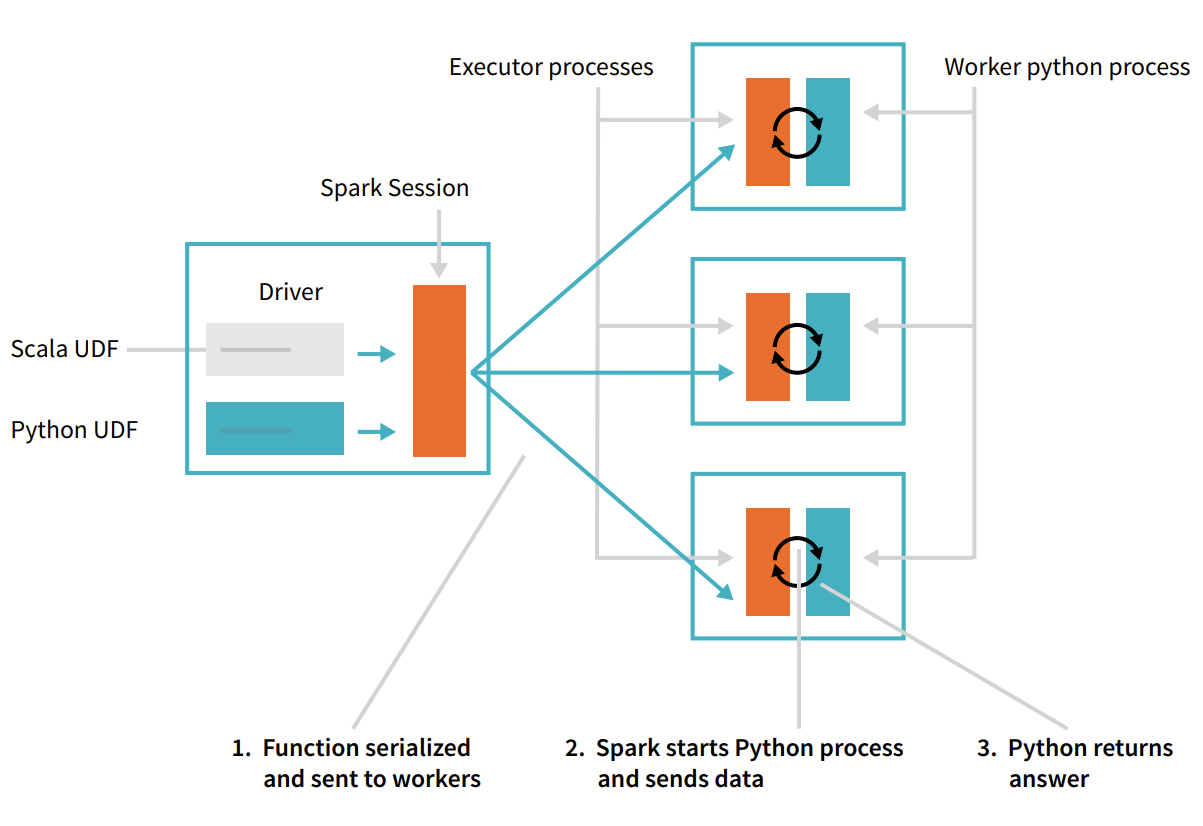

Starting up this Python process is expensive but the real cost is in serializing the data to Python. This is costly for two
reasons, it is an expensive computation but also once the data enters Python, Spark cannot manage the memory of
the worker. This means that you could potentially cause a worker to fail if it becomes resource constrained (because
both the JVM and python are competing for memory on the same machine). We recommend that you write your UDFs
in Scala - the small amount of time it should take you to write the function in Scala will always yield significant speed
ups and on top of that, you can still use the function from Python!

In [95]:
#Example
udfExampleDF = spark.range(3).toDF("num")

def power3(double_value):
    return double_value ** 3

power3(2.0)

8.0

In [92]:
from pyspark.sql.functions import udf

power3udf = udf(power3)

In [99]:
# issue with my spark/python connection
from pyspark.sql.functions import col

#udfExampleDF.select(power3udf("num")).show()

In [98]:
spark.version

'3.1.1'